# Descriptive Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('space_decay_cleaned.csv')
df.head()

,Unnamed: 0,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,...,MEAN_MOTION_DDOT,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,SITE
0,0,ARIANE 42P+ DEB,1992-072J,2021-10-31T22:46:50.340864,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,...,0.0,20668.618,492.864,27784.871,796.095,2,1,FR,1992.0,FRGUI
1,1,SL-8 DEB,1979-028C,2021-10-31T16:32:17.360448,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,...,0.0,7358.038,104.689,1002.507,957.299,2,0,CIS,1979.0,PKMTR
2,2,GSAT 1,2001-015A,2021-11-01T05:22:43.421952,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,...,0.0,41197.852,1386.984,35797.696,33841.738,0,2,IND,2001.0,SRI
3,3,CZ-4 DEB,1999-057MB,2021-10-31T11:11:24.198720,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,...,0.0,7015.076,97.456,679.465,594.417,2,0,PRC,1999.0,TSC
4,4,CZ-4 DEB,1999-057MC,2021-10-31T17:46:46.681248,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,...,0.0,7031.400,97.796,697.039,609.491,2,0,PRC,1999.0,TSC


## Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14125 non-null  int64  
 1   OBJECT_NAME        14125 non-null  object 
 2   OBJECT_ID          14125 non-null  object 
 3   EPOCH              14125 non-null  object 
 4   MEAN_MOTION        14125 non-null  float64
 5   ECCENTRICITY       14125 non-null  float64
 6   INCLINATION        14125 non-null  float64
 7   RA_OF_ASC_NODE     14125 non-null  float64
 8   ARG_OF_PERICENTER  14125 non-null  float64
 9   MEAN_ANOMALY       14125 non-null  float64
 10  NORAD_CAT_ID       14125 non-null  int64  
 11  REV_AT_EPOCH       14125 non-null  int64  
 12  BSTAR              14125 non-null  float64
 13  MEAN_MOTION_DOT    14125 non-null  float64
 14  MEAN_MOTION_DDOT   14125 non-null  float64
 15  SEMIMAJOR_AXIS     14125 non-null  float64
 16  PERIOD             141

### Necessary Adjustments

Epoch -->  2021-10-31T22:46:50.340864 (year-month-day T hour-minute-second-microsecond)  </br>
Launch_Date --> 1992.(year)

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df['EPOCH'] = pd.to_datetime(df['EPOCH'])

In [6]:
df = df.sort_values(by=['NORAD_CAT_ID', 'EPOCH']).reset_index(drop=True)

### Feature Extraction 

In [7]:
df['ALTITUDE'] = (df['PERIAPSIS'] + df['APOAPSIS']) / 2
df['ALTITUDE_RANGE'] = df['APOAPSIS'] - df['PERIAPSIS']

In [8]:
df['ORBITAL_PERIOD'] = 2*np.pi*np.sqrt((df['SEMIMAJOR_AXIS']**3) / 398600.4418)

In [9]:
df['APOPERI_RATIO']= df['APOAPSIS']/df['PERIAPSIS']

In [10]:
rcs_to_area = {0:0.05, 1:0.5, 2:5.0}
df['CROSS_SECTIONAL_AREA'] = df['RCS_SIZE'].map(rcs_to_area)
df['DRAG_EFFECTIVE_AREA'] = df['BSTAR']*df['CROSS_SECTIONAL_AREA']

In [11]:
def estimate_decay_time(row):
    if row['PERIAPSIS'] < 150:
        return 0
    else:
        periapsis = max(row['PERIAPSIS'], 150)
        bstar = max(row['BSTAR'], 1e-6)
        size_factor = 1 if row['RCS_SIZE'] == 0 else 1.5 if row['RCS_SIZE'] == 1 else 2

        estimated_time = (periapsis / (bstar * size_factor)) * 0.75
        return min(round(estimated_time), 10000)  # Cap at 10,000 days

df['ESTIMATED_DECAY_EPOCH'] = df.apply(estimate_decay_time, axis=1)
df['EPOCH'] = pd.to_datetime(df['EPOCH'], errors='coerce')

df['ESTIMATED_DECAY_EPOCH'] = df['EPOCH'] + pd.to_timedelta(df['ESTIMATED_DECAY_EPOCH'], unit='D')


In [12]:
df['ORBITAL_DECAY_TIME'] = (df['ESTIMATED_DECAY_EPOCH'] - df['EPOCH']).dt.days

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   OBJECT_NAME            14125 non-null  object        
 1   OBJECT_ID              14125 non-null  object        
 2   EPOCH                  14125 non-null  datetime64[ns]
 3   MEAN_MOTION            14125 non-null  float64       
 4   ECCENTRICITY           14125 non-null  float64       
 5   INCLINATION            14125 non-null  float64       
 6   RA_OF_ASC_NODE         14125 non-null  float64       
 7   ARG_OF_PERICENTER      14125 non-null  float64       
 8   MEAN_ANOMALY           14125 non-null  float64       
 9   NORAD_CAT_ID           14125 non-null  int64         
 10  REV_AT_EPOCH           14125 non-null  int64         
 11  BSTAR                  14125 non-null  float64       
 12  MEAN_MOTION_DOT        14125 non-null  float64       
 13  M

In [16]:
df.columns

Index(['OBJECT_NAME', 'OBJECT_ID', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY',
       'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
       'NORAD_CAT_ID', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
       'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
       'OBJECT_TYPE', 'RCS_SIZE', 'COUNTRY_CODE', 'LAUNCH_DATE', 'SITE',
       'ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD', 'APOPERI_RATIO',
       'CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA', 'ESTIMATED_DECAY_EPOCH',
       'ORBITAL_DECAY_TIME'],
      dtype='object')

In [44]:
df.to_csv('space_decay_wf.csv', index=False) # space_decay_wf --> wf:with features

In [25]:
numeric_columns = ['MEAN_MOTION', 'ECCENTRICITY','INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA',
                    'ORBITAL_DECAY_TIME']

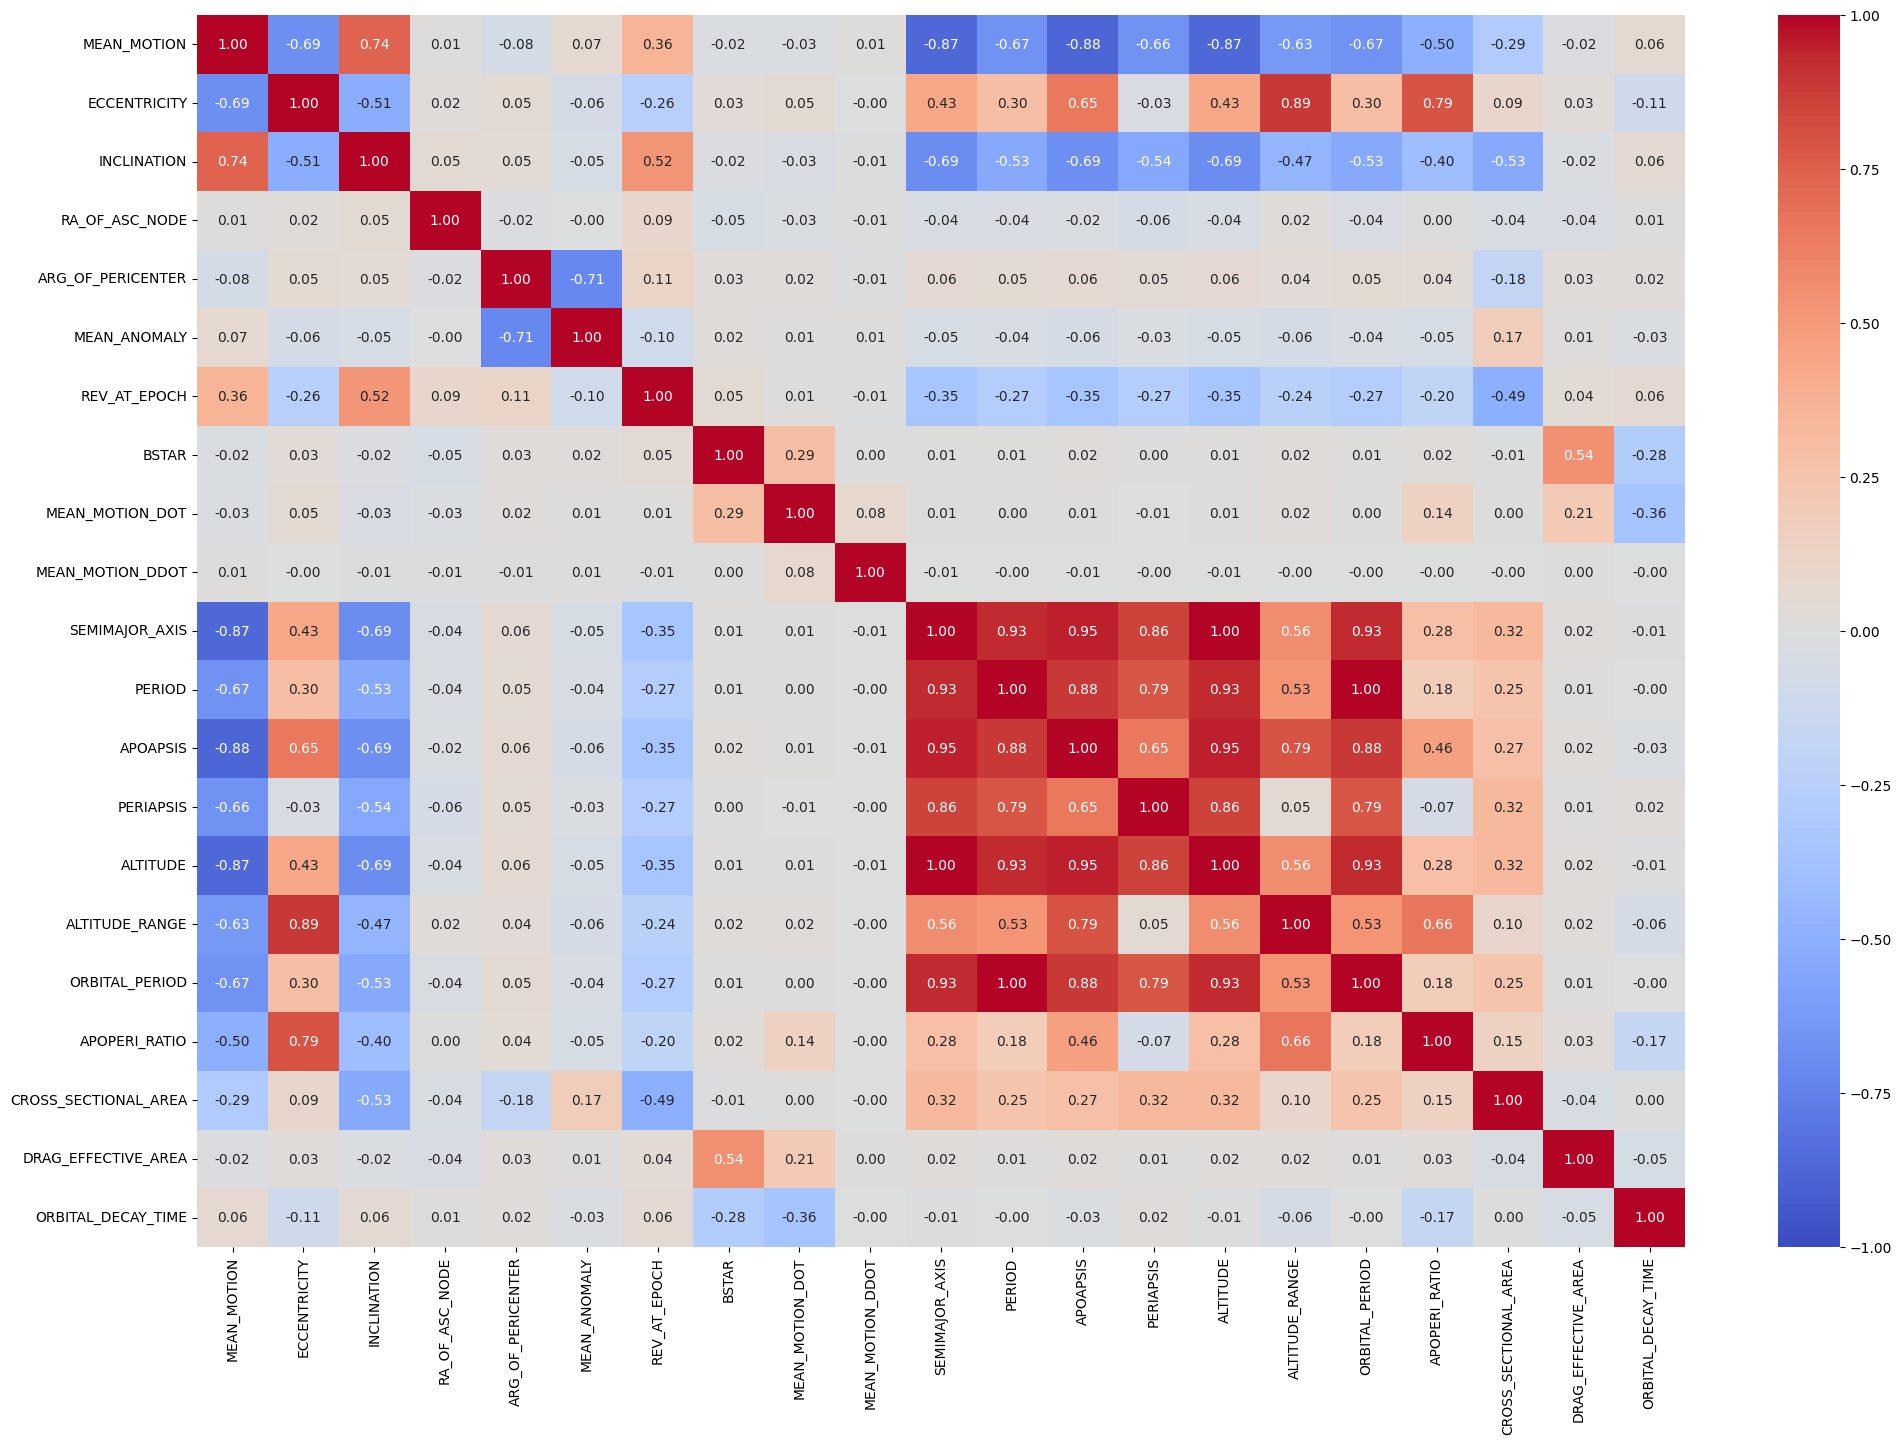

In [26]:
plt.figure(figsize=(24, 16))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()

## VIF (Variance Inflation Factor)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[numeric_columns].dropna()
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


/home/sinem/miniconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [31]:
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #0e2433; color: white; text-align: center;"
}
properties = {"border": "1px solid black", "width": "65px", "text-align": "center"}

vif_df.style.hide(axis="index").set_table_styles([headers]).set_properties(**properties)

feature,VIF
MEAN_MOTION,36.087829
ECCENTRICITY,27.793174
INCLINATION,3.538136
RA_OF_ASC_NODE,1.022045
ARG_OF_PERICENTER,2.084731
MEAN_ANOMALY,2.065921
REV_AT_EPOCH,1.552232
BSTAR,1.601493
MEAN_MOTION_DOT,1.247839
MEAN_MOTION_DDOT,1.008401


/tmp/ipykernel_1423869/830508809.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=filtered_vif_df, palette=palette)


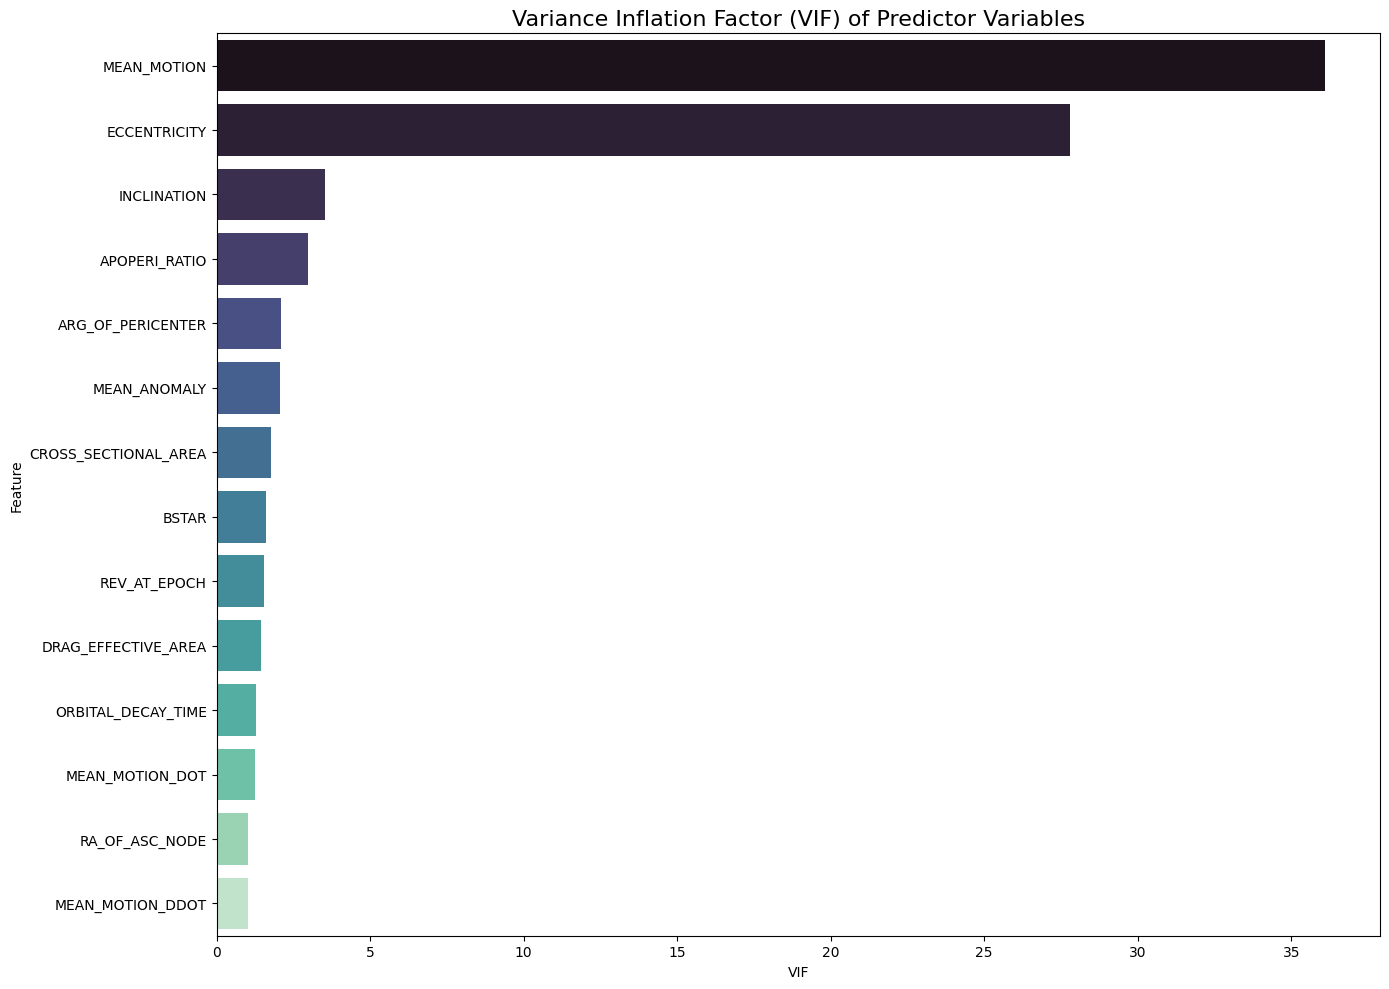

In [33]:
# Filter out infinite or extremely large VIFs
filtered_vif_df = vif_df.copy()
filtered_vif_df = filtered_vif_df.replace([np.inf, -np.inf], np.nan).dropna()
filtered_vif_df = filtered_vif_df[filtered_vif_df["VIF"] < 1000]  # Example threshold

# Sort by VIF
filtered_vif_df = filtered_vif_df.sort_values(by='VIF', ascending=False)

# Visualization
palette = sns.color_palette("mako", n_colors=len(filtered_vif_df))
plt.figure(figsize=(14, 10))
sns.barplot(x="VIF", y="feature", data=filtered_vif_df, palette=palette)
plt.title("Variance Inflation Factor (VIF) of Predictor Variables", fontsize=16)
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

> The Variance Inflation Factor (VIF) measures how much a variable is collinear with other variables in the dataset. A VIF value of 1 indicates no multicollinearity, which is ideal. Values greater than 5 suggest potential multicollinearity, and values above 10 indicate a high level of redundancy that may require dropping or combining variables. Based on this, I decided to drop MEAN_MOTION and ECCENTRICITY from the analysis due to their high VIF scores, which could negatively impact model performance and interpretability.

In [34]:
df = df.drop(columns=['MEAN_MOTION', 'ECCENTRICITY'], errors='ignore', axis=1)

## Mutual Information

In [41]:
columns_to_mi=['INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA']

/tmp/ipykernel_1423869/2773711981.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="mutual_info", y="feature", data=mi_df, palette='viridis')


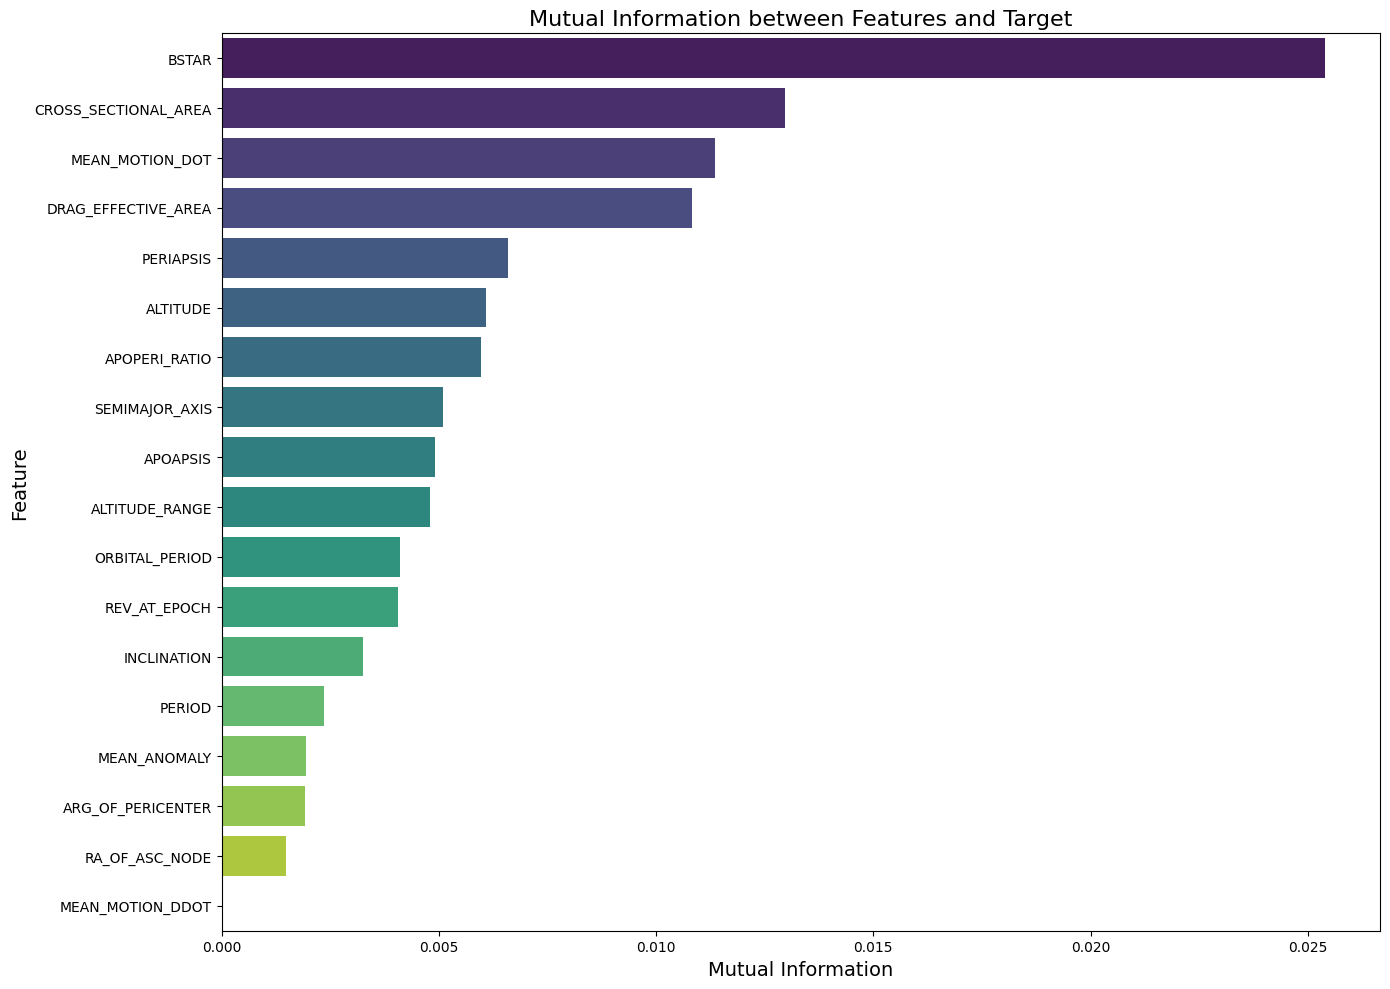

In [42]:
from sklearn.feature_selection import mutual_info_regression

x = df[columns_to_mi]
y= df['ORBITAL_DECAY_TIME']

mutual_info = mutual_info_regression(x,y)

mi_df = pd.DataFrame({'feature': x.columns, 'mutual_info': mutual_info})

mi_df = mi_df.sort_values(by='mutual_info', ascending=False)
plt.figure(figsize=(14, 10))
sns.barplot(x="mutual_info", y="feature", data=mi_df, palette='viridis')    
plt.title('Mutual Information between Features and Target', fontsize=16)
plt.xlabel('Mutual Information', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

> Mutual Information (MI) measures how much information one variable provides about another, helping to quantify the dependency between them. In the context of feature selection, it indicates how much knowing a particular feature reduces uncertainty about the target variable. Unlike simple correlation, MI is capable of capturing both linear and non-linear relationships, making it a powerful tool for identifying which features are most informative for predictive modeling.

## PCA (Principal Component Analysis: Dimensionality Reduction)

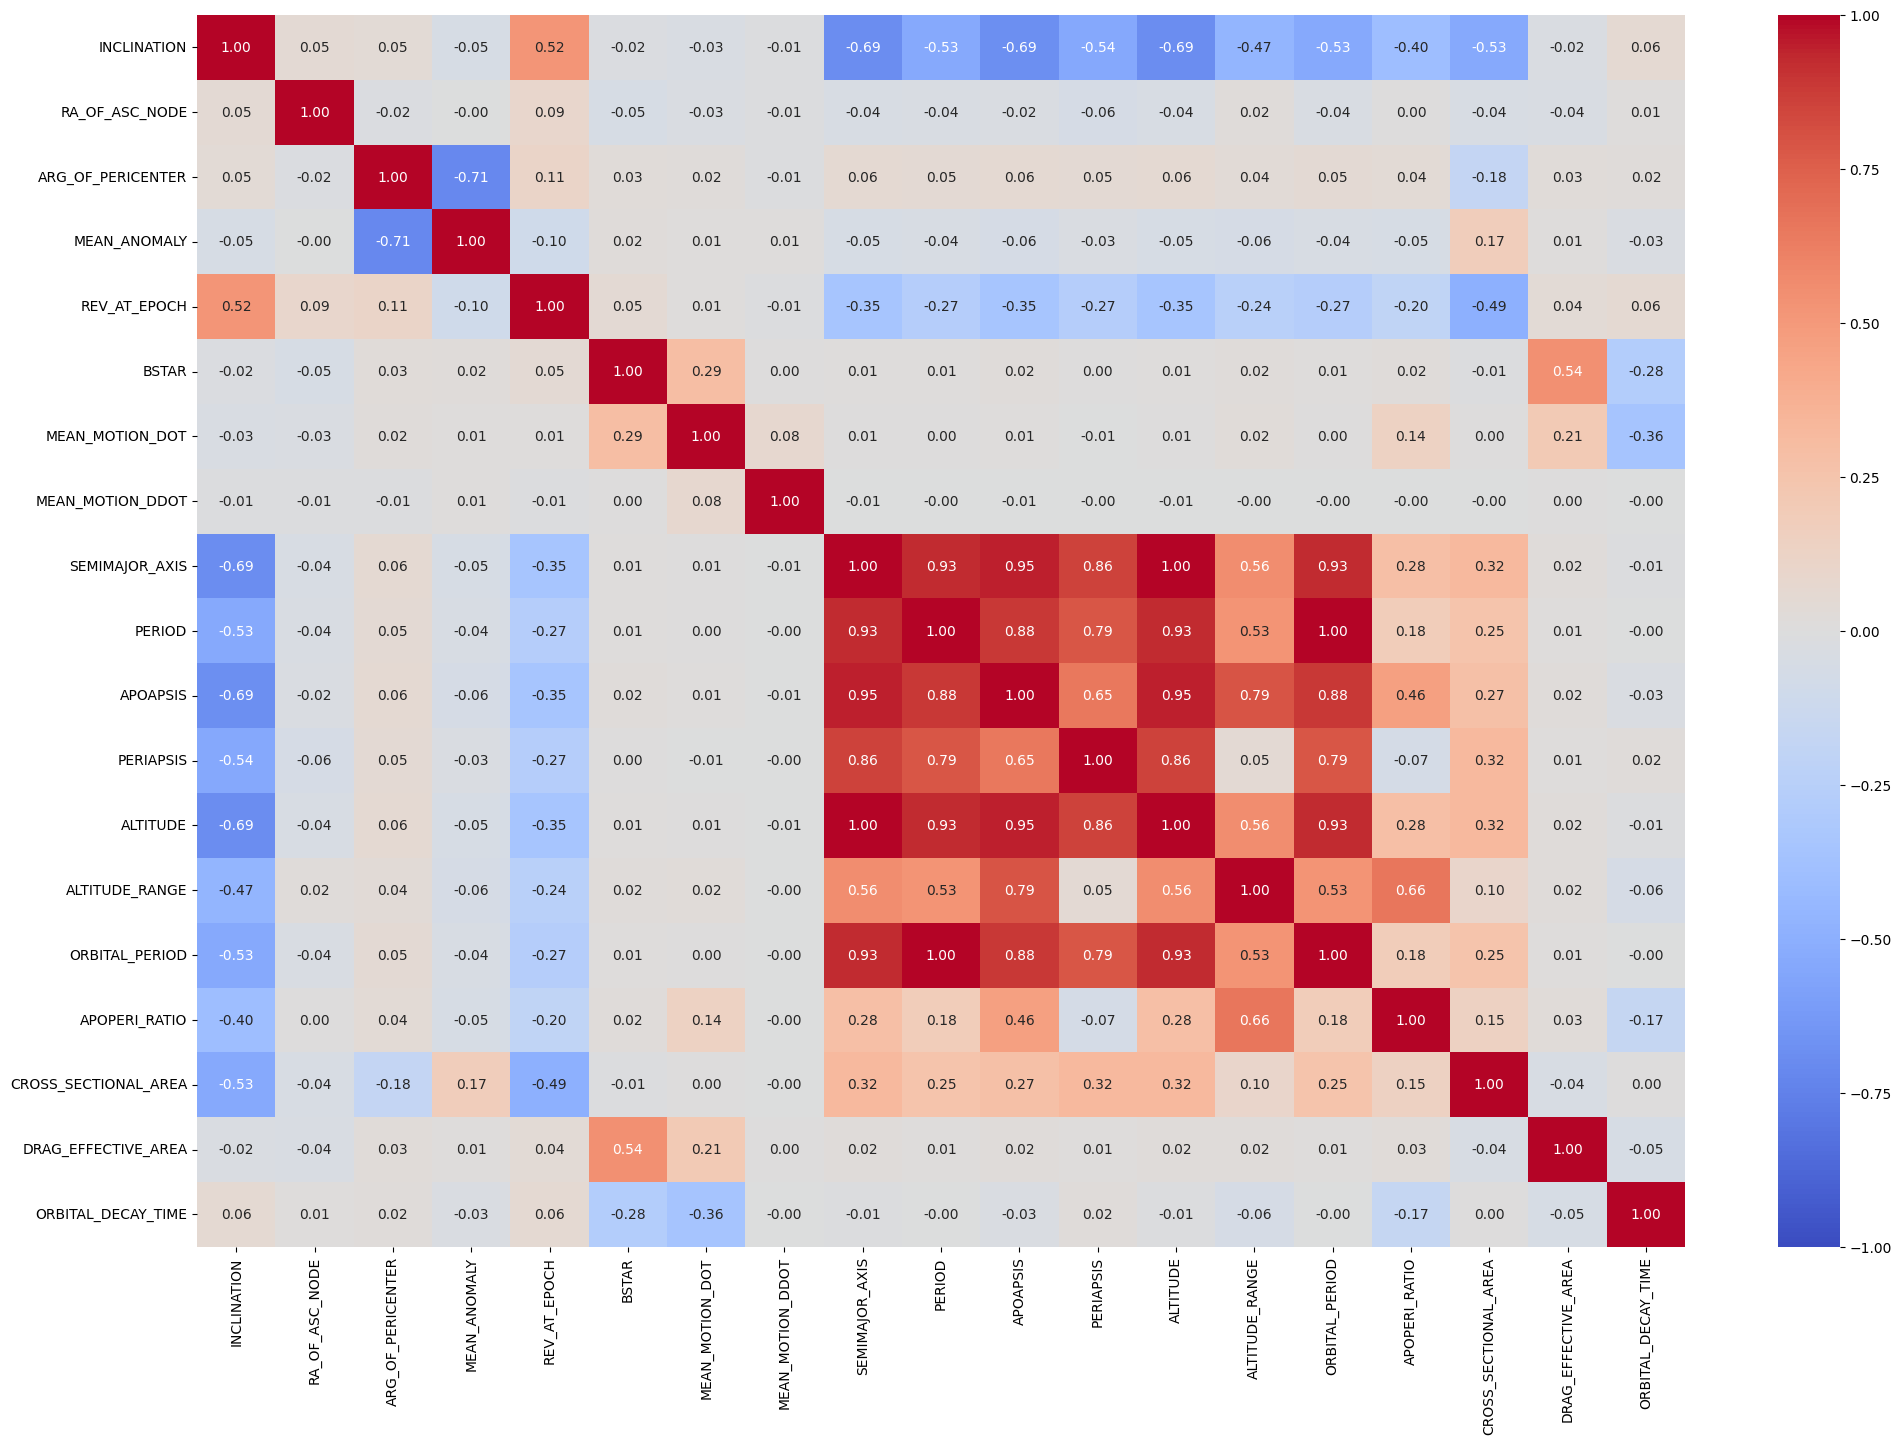

In [43]:
columns=['INCLINATION', 'RA_OF_ASC_NODE', 
                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY','REV_AT_EPOCH', 'BSTAR',
                    'MEAN_MOTION_DOT','MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD',
                    'APOAPSIS', 'PERIAPSIS','ALTITUDE', 'ALTITUDE_RANGE', 'ORBITAL_PERIOD',
                    'APOPERI_RATIO','CROSS_SECTIONAL_AREA', 'DRAG_EFFECTIVE_AREA', 'ORBITAL_DECAY_TIME']
plt.figure(figsize=(24, 16))
sns.heatmap(df[columns].corr(), annot=True, cmap='coolwarm',  fmt=".2f", vmin=-1, vmax=1)
plt.show()